In [1]:
#Install core dependencies (skip if already installed)
%pip install pandas numpy scikit-learn matplotlib seaborn shap tensorflow==2.10.1 eli5 numba==0.56.4

#Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Sklearn
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# TensorFlow / Keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Explainability tools
import shap
import eli5
from eli5.sklearn import PermutationImportance


Note: you may need to restart the kernel to use updated packages.


c:\Users\dorna\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import pandas as pd

# Define the file path
file_path = r"Data Training\Machine Learning\salaries.csv"

# Load the dataset
try:
    df = pd.read_csv(file_path)
    print("Dataset successfully loaded!")
except FileNotFoundError:
    print(" ERROR: File not found. Please check the file path.")
except Exception as e:
    print(f" ERROR: {e}")

# Display basic information
print("\n Dataset Info:")
print(df.info())  # Check column types and missing values

# Display first few rows to verify
print("\n Sample Data:")
print(df.head())


Dataset successfully loaded!

 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88584 entries, 0 to 88583
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           88584 non-null  int64 
 1   experience_level    88584 non-null  object
 2   employment_type     88584 non-null  object
 3   job_title           88584 non-null  object
 4   salary              88584 non-null  int64 
 5   salary_currency     88584 non-null  object
 6   salary_in_usd       88584 non-null  int64 
 7   employee_residence  88584 non-null  object
 8   remote_ratio        88584 non-null  int64 
 9   company_location    88584 non-null  object
 10  company_size        88584 non-null  object
dtypes: int64(4), object(7)
memory usage: 7.4+ MB
None

 Sample Data:
   work_year experience_level employment_type                 job_title  \
0       2025               MI              FT  Customer Success Manager   
1 

In [4]:
# Make a copy of the original dataframe to avoid accidental overwrites
df_clean = df.copy()

# Drop 'salary' and 'salary_currency' — we'll only use 'salary_in_usd'
df_clean.drop(columns=["salary", "salary_currency"], inplace=True)

#  Display the new structure
print("\n Columns after dropping:")
print(df_clean.columns)

# Check for null values again just in case
print("\n Missing Values Check:")
print(df_clean.isnull().sum())

# Show sample data
print("\n Cleaned Sample:")
print(df_clean.head())


 Columns after dropping:
Index(['work_year', 'experience_level', 'employment_type', 'job_title',
       'salary_in_usd', 'employee_residence', 'remote_ratio',
       'company_location', 'company_size'],
      dtype='object')

 Missing Values Check:
work_year             0
experience_level      0
employment_type       0
job_title             0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64

 Cleaned Sample:
   work_year experience_level employment_type                 job_title  \
0       2025               MI              FT  Customer Success Manager   
1       2025               SE              FT                  Engineer   
2       2025               SE              FT                  Engineer   
3       2025               SE              FT         Applied Scientist   
4       2025               SE              FT         Applied Scientist   

   salary_in_usd employee_residence  remote_ratio co

In [5]:
# Recalculate group medians after encoding and scaling
group_median = df_clean.groupby(['experience_level', 'job_title'])['salary_in_usd'].median()

# Create the binary "is_fairly_paid" label
df_clean["median_salary"] = df_clean.apply(
    lambda row: group_median.loc[row["experience_level"], row["job_title"]],
    axis=1
)

df_clean["is_fairly_paid"] = (df_clean["salary_in_usd"] >= df_clean["median_salary"]).astype(int)

# Drop helper column
df_clean.drop(columns=["median_salary"], inplace=True)

# Final check
print(df_clean.columns)
print(df_clean["is_fairly_paid"].value_counts())


Index(['work_year', 'experience_level', 'employment_type', 'job_title',
       'salary_in_usd', 'employee_residence', 'remote_ratio',
       'company_location', 'company_size', 'is_fairly_paid'],
      dtype='object')
is_fairly_paid
1    45210
0    43374
Name: count, dtype: int64


In [6]:
from sklearn.model_selection import train_test_split

# Define features and target
X = df_clean.drop(columns=["is_fairly_paid"])
y = df_clean["is_fairly_paid"]

# Split: 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Data Split Completed")
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)


Data Split Completed
Training set shape: (70867, 9)
Testing set shape: (17717, 9)


In [8]:
import numpy as np

# Convert inputs to NumPy arrays
X_train_np = X_train.to_numpy()
y_train_np = y_train.to_numpy()
X_test_np = X_test.to_numpy()
y_test_np = y_test.to_numpy()


In [ ]:
# Ensure model_v1 is defined
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Define the model
input_dim = X_train_np.shape[1]
model_v1 = Sequential([
    Dense(32, activation='relu', input_shape=(input_dim,)),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model_v1.compile(optimizer=Adam(learning_rate=0.001),
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

# Encode categorical variables in X_train and X_test
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Identify categorical columns
categorical_columns = ['experience_level', 'employment_type', 'job_title', 'employee_residence', 'company_location', 'company_size']

# Apply one-hot encoding to categorical columns
column_transformer = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ],
    remainder='passthrough'  # Keep other columns as is
)

X_train_np = column_transformer.fit_transform(X_train)
X_test_np = column_transformer.transform(X_test)

# Convert NumPy arrays to float32
X_train_np = X_train_np.astype('float32')
y_train_np = y_train_np.astype('float32')
X_test_np = X_test_np.astype('float32')
y_test_np = y_test_np.astype('float32')

# Convert sparse matrices to dense arrays for training
X_train_np_dense = X_train_np.toarray()

# TRAINING
history_v1 = model_v1.fit(X_train_np_dense, y_train_np,
                          validation_split=0.4,
                          epochs=25,
                          batch_size=64,
                          verbose=1)

# EVALUATION ON TEST SET
loss_v1, accuracy_v1 = model_v1.evaluate(X_test_np, y_test_np)


Epoch 1/25
665/665 [==============================] - 2s 3ms/step - loss: 123.9480 - accuracy: 0.7268 - val_loss: 1.8013 - val_accuracy: 0.7866
Epoch 2/25
665/665 [==============================] - 2s 3ms/step - loss: 3.1204 - accuracy: 0.7410 - val_loss: 1.2948 - val_accuracy: 0.8160
Epoch 3/25
665/665 [==============================] - 2s 3ms/step - loss: 3.3484 - accuracy: 0.7367 - val_loss: 1.5052 - val_accuracy: 0.8212
Epoch 4/25
665/665 [==============================] - 2s 3ms/step - loss: 3.3701 - accuracy: 0.7452 - val_loss: 10.3185 - val_accuracy: 0.4956
Epoch 5/25
665/665 [==============================] - 2s 3ms/step - loss: 2.9755 - accuracy: 0.7531 - val_loss: 1.1084 - val_accuracy: 0.8170
Epoch 6/25
665/665 [==============================] - 2s 3ms/step - loss: 3.1047 - accuracy: 0.7458 - val_loss: 1.1343 - val_accuracy: 0.8319
Epoch 7/25
665/665 [==============================] - 2s 3ms/step - loss: 2.8241 - accuracy: 0.7544 - val_loss: 3.5174 - val_accuracy: 0.6167
Epo

In [23]:
# PREDICTION
y_pred_probs = model_v1.predict(X_test_np)
y_pred = (y_pred_probs > 0.5).astype(int)

554/554 [==============================] - 1s 1ms/step


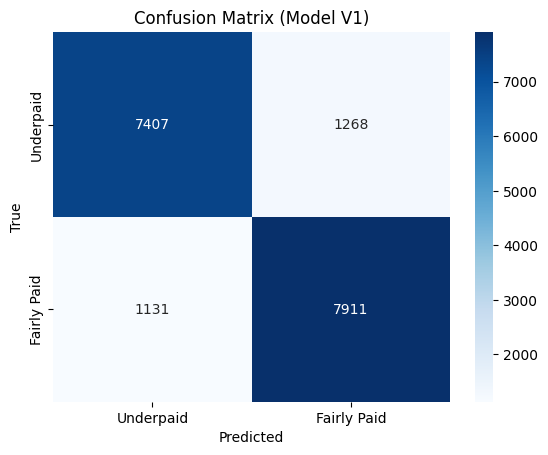

In [24]:
#  CONFUSION MATRIX
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Underpaid", "Fairly Paid"], yticklabels=["Underpaid", "Fairly Paid"])
plt.title("Confusion Matrix (Model V1)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

model_v2 = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_np_dense.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_v2.compile(optimizer=Adam(learning_rate=0.001),
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

history_v2 = model_v2.fit(X_train_np_dense, y_train_np,
                          validation_split=0.2,
                          epochs=20,
                          batch_size=64,
                          verbose=1)

# Convert sparse matrix to dense array for evaluation
X_test_np_dense = X_test_np.toarray()

loss_v2, accuracy_v2 = model_v2.evaluate(X_test_np_dense, y_test_np)

Epoch 1/20
886/886 [==============================] - 4s 3ms/step - loss: 124.4955 - accuracy: 0.5177 - val_loss: 0.6602 - val_accuracy: 0.5571
Epoch 2/20
886/886 [==============================] - 3s 3ms/step - loss: 1.7789 - accuracy: 0.5848 - val_loss: 0.6193 - val_accuracy: 0.7715
Epoch 3/20
886/886 [==============================] - 3s 3ms/step - loss: 0.9505 - accuracy: 0.6043 - val_loss: 0.6314 - val_accuracy: 0.6457
Epoch 4/20
886/886 [==============================] - 3s 3ms/step - loss: 0.7940 - accuracy: 0.6120 - val_loss: 0.5665 - val_accuracy: 0.7659
Epoch 5/20
886/886 [==============================] - 3s 3ms/step - loss: 0.7398 - accuracy: 0.6322 - val_loss: 0.5452 - val_accuracy: 0.7342
Epoch 6/20
886/886 [==============================] - 3s 3ms/step - loss: 0.6606 - accuracy: 0.6678 - val_loss: 0.5348 - val_accuracy: 0.8190
Epoch 7/20
886/886 [==============================] - 3s 3ms/step - loss: 0.6042 - accuracy: 0.6998 - val_loss: 0.4945 - val_accuracy: 0.7676
Epoc

In [30]:
from tensorflow.keras.regularizers import l2

model_v3 = Sequential([
    Dense(64, activation='relu', kernel_regularizer=l2(0.01), input_shape=(X_train_np_dense.shape[1],)),
    Dropout(0.5),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_v3.compile(optimizer=Adam(learning_rate=0.001),
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

history_v3 = model_v3.fit(X_train_np_dense, y_train_np,
                          validation_split=0.2,
                          epochs=20,
                          batch_size=64,
                          verbose=1)

loss_v3, accuracy_v3 = model_v3.evaluate(X_test_np_dense, y_test_np)


Epoch 1/20
886/886 [==============================] - 3s 3ms/step - loss: 223.4486 - accuracy: 0.5001 - val_loss: 0.9893 - val_accuracy: 0.4887
Epoch 2/20
886/886 [==============================] - 2s 3ms/step - loss: 2.3927 - accuracy: 0.4931 - val_loss: 0.9823 - val_accuracy: 0.4887
Epoch 3/20
886/886 [==============================] - 2s 3ms/step - loss: 1.4055 - accuracy: 0.4945 - val_loss: 0.9771 - val_accuracy: 0.5113
Epoch 4/20
886/886 [==============================] - 2s 3ms/step - loss: 1.2299 - accuracy: 0.5067 - val_loss: 0.9713 - val_accuracy: 0.5113
Epoch 5/20
886/886 [==============================] - 2s 3ms/step - loss: 1.1229 - accuracy: 0.5096 - val_loss: 0.9645 - val_accuracy: 0.5113
Epoch 6/20
886/886 [==============================] - 2s 3ms/step - loss: 1.0266 - accuracy: 0.5101 - val_loss: 0.9558 - val_accuracy: 0.5113
Epoch 7/20
886/886 [==============================] - 2s 3ms/step - loss: 0.9821 - accuracy: 0.5102 - val_loss: 0.9444 - val_accuracy: 0.5113
Epoc

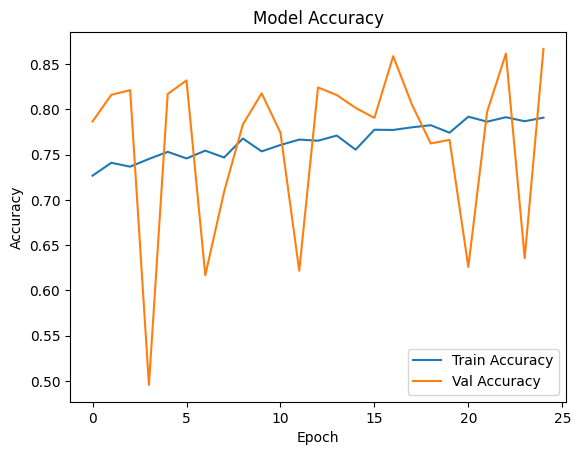

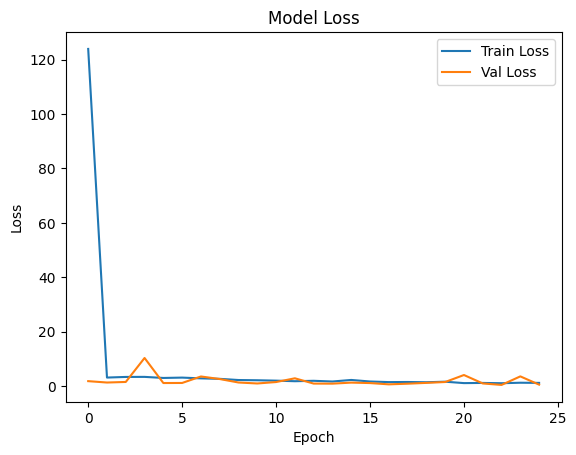

In [ ]:
# Accuracy
plt.plot(history_v1.history['accuracy'], label='Train Accuracy')
plt.plot(history_v1.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history_v1.history['loss'], label='Train Loss')
plt.plot(history_v1.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


554/554 [==============================] - 2s 4ms/step


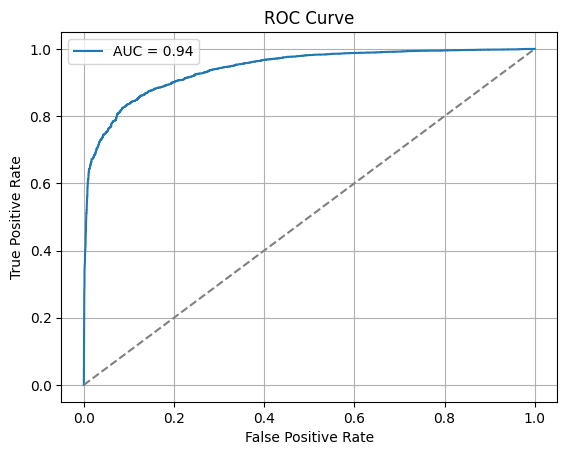

In [ ]:
#Using one-hot encoding, decode y_test:
if y_test.ndim > 1 and y_test.shape[1] == 2:
    y_test = y_test.argmax(axis=1)

# Get probability for the positive class (class 1)
y_pred_prob = model_v1.predict(X_test_np_dense)[:, 0]

#Plot ROC
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()



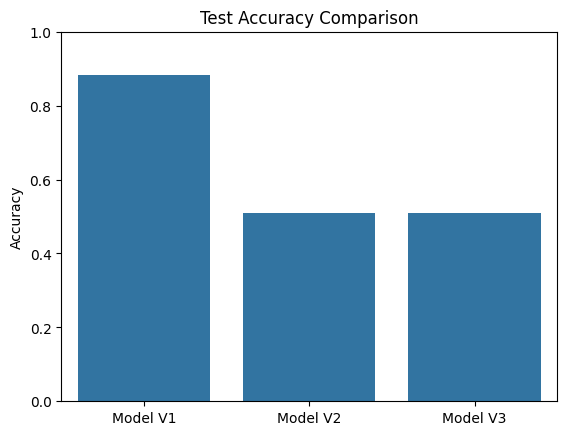

In [ ]:
#Bar plot comparing test accuracies of the three models
sns.barplot(x=["Model V1", "Model V2", "Model V3"], y=[0.882, 0.510, 0.510])
plt.title('Test Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()


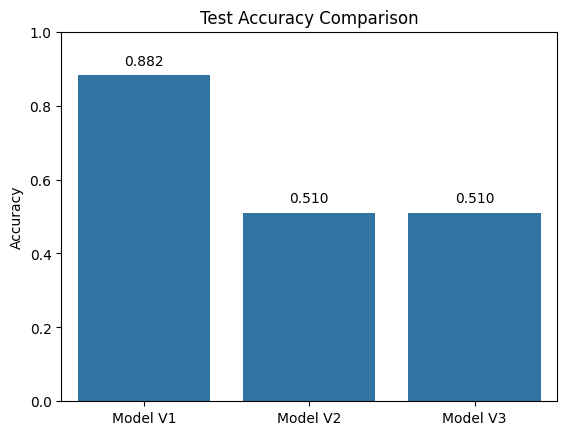

In [ ]:
# Data
models = ["Model V1", "Model V2", "Model V3"]
accuracies = [0.882, 0.510, 0.510]

# Barplot
sns.barplot(x=models, y=accuracies)
plt.title('Test Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)

# Add value labels
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.02, f"{acc:.3f}", ha='center', va='bottom')

plt.show()